In [1]:
import pandas as pd

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from tqdm import tqdm_notebook
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
%matplotlib inline


/home/ashish/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
sales_data = pd.read_csv('./train.csv')

/home/ashish/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
sales_data.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [3]:
stores_data = pd.read_csv('./store.csv')

In [4]:
test_data = pd.read_csv('./test.csv')

In [83]:
stores_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [200]:
sales_data.shape

(1017209, 10)

In [201]:
stores_data.shape

(1115, 10)

In [5]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [151]:
# In order to simultaneously change the features of test and train, we will combine the data sets

sales_data['Set'] = 1
test_data['Set'] = 0
full_df = pd.concat([sales_data,test_data])

In [9]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 11 columns):
Customers        1017209 non-null float64
Date             1058297 non-null object
DayOfWeek        1058297 non-null int64
Id               41088 non-null float64
Open             1058286 non-null float64
Promo            1058297 non-null int64
Sales            1017209 non-null float64
SchoolHoliday    1058297 non-null int64
Set              1058297 non-null int64
StateHoliday     1058297 non-null object
Store            1058297 non-null int64
dtypes: float64(4), int64(5), object(2)
memory usage: 96.9+ MB


## Exploratory Data Analysis

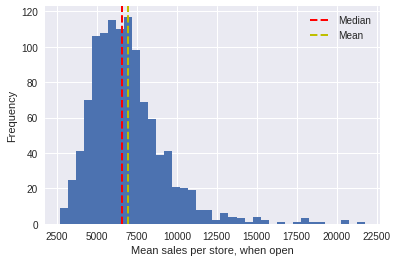

In [5]:
# Extracting data where stores were open
sales_when_store_open = sales_data[sales_data['Open'] == 1]

# Average sales by each Storeb
mean_sales = sales_when_store_open['Sales'].groupby(sales_when_store_open.Store).aggregate(np.mean)

# Frequency distribution of sales per store
## Optimal number of bins: h = 2 * IQR * n^(-1/3), opt. bins = (max - min)/ h
### Calculate IQR

q75, q25 = np.percentile(mean_sales, [75 ,25])
iqr = q75 - q25


bin_width = (max(mean_sales) - min(mean_sales)) / (2 * iqr * len(mean_sales)**(-1/3))

plt.xlabel('Mean sales per store, when open')
plt.ylabel('Frequency')
mean_sales.hist(bins=math.ceil(bin_width))

plt.axvline(mean_sales.median(), color='r', linestyle='dashed', linewidth=2, label='Median')
plt.axvline(mean_sales.mean(), color='y', linestyle='dashed', linewidth=2, label='Mean')
plt.legend()
plt.savefig('eda1.png')

In [12]:
# Average Customers per day in each store
customers_per_day = sales_data['Customers'].groupby(sales_data.DayOfWeek).aggregate(np.mean)

# Average Sales per day in each store
sales_per_day = sales_data['Sales'].groupby(sales_data.DayOfWeek).aggregate(np.mean)

In [13]:
# Average Sales per day in a week with respect to 'Open' stores
normalized_sales_per_day = sales_when_store_open['Sales'].groupby(sales_when_store_open.DayOfWeek).aggregate(np.mean)

# Average Count of customers per day with respect to 'Open' stores
normalized_customer_count = sales_when_store_open['Customers'].groupby(sales_when_store_open.DayOfWeek).aggregate(np.mean)

### Average Sales and Customers per day

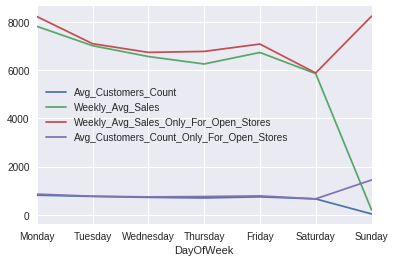

In [199]:
# Plot
x_axes = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(1, 1)

plt.xticks([1,2,3,4,5,6,7], x_axes)

#Renaming names of series
customers_per_day.name = 'Avg_Customers_Count'
sales_per_day.name = 'Weekly_Avg_Sales'
normalized_sales_per_day.name = 'Weekly_Avg_Sales_Only_For_Open_Stores'
normalized_customer_count.name = 'Avg_Customers_Count_Only_For_Open_Stores'

customers_per_day.plot(kind='line', legend=True)
sales_per_day.plot(kind='line', legend=True)
normalized_sales_per_day.plot(kind='line', legend=True)
normalized_customer_count.plot(kind='line', legend=True)

plt.savefig('eda_2.png')

In [17]:
# Unusual stores which are 'Open' but no 'Sales'
sales_when_store_open[(sales_when_store_open.Open == 1) & (sales_when_store_open.Sales == 0)]


,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,Set,StateHoliday,Store
86825,0.0,2015-05-15,5,NaN,1.0,0,0.0,1,1,0,971
142278,0.0,2015-03-26,4,NaN,1.0,0,0.0,0,1,0,674
196938,0.0,2015-02-05,4,NaN,1.0,1,0.0,0,1,0,699
322053,0.0,2014-10-01,3,NaN,1.0,1,0.0,0,1,0,708
330176,0.0,2014-09-22,1,NaN,1.0,0,0.0,0,1,0,357
340348,0.0,2014-09-11,4,NaN,1.0,0,0.0,0,1,0,227
340860,0.0,2014-09-11,4,NaN,1.0,0,0.0,0,1,0,835
341795,0.0,2014-09-10,3,NaN,1.0,0,0.0,0,1,0,835
346232,0.0,2014-09-05,5,NaN,1.0,1,0.0,1,1,0,548
346734,0.0,2014-09-04,4,NaN,1.0,1,0.0,0,1,0,28


In [7]:
# Removing these unusual stores

sales_when_store_open = sales_when_store_open.loc[~((sales_when_store_open['Open'] == 1) & (sales_when_store_open['Sales'] == 0))]

In [6]:
# StateHoliday variable contains 0 and "0", combining those to be 0 and make it categorical
#merged_df['StoreType'] = merged_df['StoreType'].astype('category').cat.codes
#merged_df['Assortment'] = merged_df['Assortment'].astype('category').cat.codes

sales_when_store_open['StateHoliday'].replace(0, "0", inplace=True)

sales_when_store_open["StateHoliday"] = sales_when_store_open["StateHoliday"].astype('category').cat.codes

/home/ashish/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3813: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/ashish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [9]:
sales_when_store_open['StateHoliday'].value_counts()

0    843428
1       694
2       145
3        71
Name: StateHoliday, dtype: int64

In [10]:
# Average Sales by state holiday
sales_by_state_holiday = sales_when_store_open['Sales'].groupby(sales_when_store_open.StateHoliday).aggregate(np.mean)

# Average Sales by promo
sales_by_promo = sales_when_store_open['Sales'].groupby(sales_when_store_open.Promo).aggregate(np.mean)

# Average customers by promo
cust_by_promo = sales_when_store_open['Customers'].groupby(sales_when_store_open.Promo).aggregate(np.mean)

In [104]:
cust_by_promo

Promo
0    696.906080
1    844.481433
Name: Customers, dtype: float64

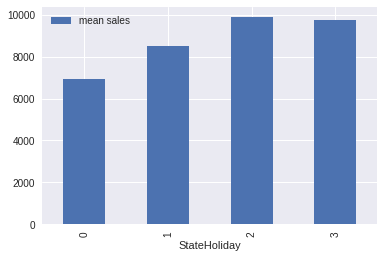

In [12]:
x_axes = ['None', 'Public Holiday', 'Easter', 'Christmas']
fig, ax = plt.subplots(1, 1)

plt.xticks([0,1,2,3], x_axes)
sales_by_state_holiday.plot(kind='bar', label='mean sales')
plt.legend()
plt.savefig('eda_state_holiday.png')

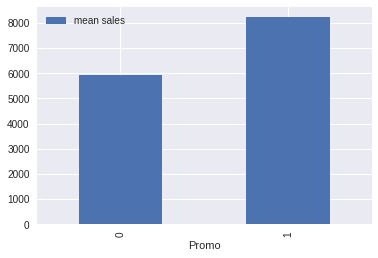

In [21]:
# Average sales of customers with/without promos

sales_by_promo.plot(kind='bar', label='mean sales')
plt.legend()
plt.savefig('eda_promo_1.png')

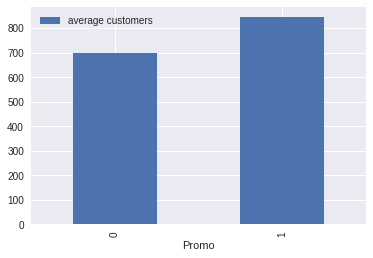

In [20]:
# Average number of customers with/without promos

cust_by_promo.plot(kind='bar', label='average customers')
plt.legend()
plt.savefig('eda_promo_2.png')

In [13]:
# Count of 'StateHoliday'
count_state_holiday = sales_when_store_open['Sales'].groupby(sales_when_store_open.StateHoliday).aggregate(np.count_nonzero)

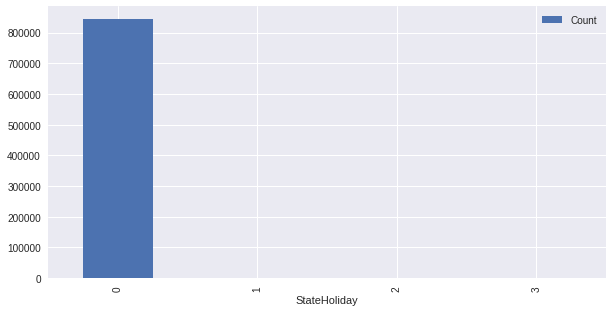

In [19]:
plt.figure(figsize=(10,5))
count_state_holiday.plot(kind='bar', label='Count')
plt.legend()
plt.savefig('foo.png')


In [15]:
masked_sales['StateHoliday'].value_counts()

NameError: name 'masked_sales' is not defined

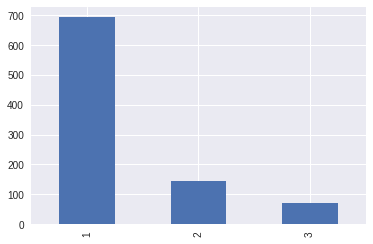

In [16]:
mask = (sales_when_store_open["StateHoliday"] != 0) & (sales_when_store_open["Sales"] > 0)

masked_sales = sales_when_store_open[mask]

masked_sales['StateHoliday'].value_counts().plot(kind='bar', label='Count')
plt.savefig('foo1.png')

In [30]:
# Combining StateHoliday == b and c (or 2 and 3)

sales_when_store_open['StateHoliday'].replace(3, 2, inplace=True)

In [31]:
sales_when_store_open['StateHoliday'].value_counts()

0    878495
1       720
2       216
Name: StateHoliday, dtype: int64

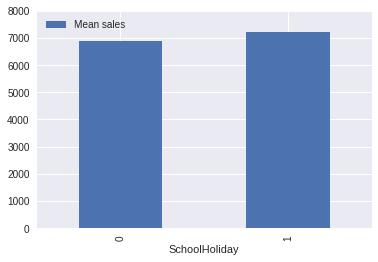

In [24]:
# School holiday

#fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sales_by_school_holiday = sales_when_store_open['Sales'].groupby(sales_when_store_open.SchoolHoliday).aggregate(np.mean)

cust_by_school_holiday = sales_when_store_open['Customers'].groupby(sales_when_store_open.SchoolHoliday).aggregate(np.mean)

sales_by_school_holiday.plot(kind='bar', label='Mean sales', ylim=(0,8000))

plt.legend()
plt.savefig('eda_school_1.png')


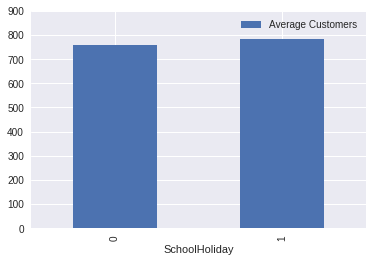

In [23]:
cust_by_school_holiday.plot(kind='bar', label='Average Customers', ylim=(0,900) )
plt.legend()
plt.savefig('eda_school_2.png')

In [25]:
# Joining stores and train data
merged_df = pd.merge(sales_when_store_open, stores_data, on='Store')

In [26]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 18 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Date                         844338 non-null object
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null int8
SchoolHoliday                844338 non-null int64
StoreType                    844338 non-null object
Assortment                   844338 non-null object
CompetitionDistance          842152 non-null float64
CompetitionOpenSinceMonth    575738 non-null float64
CompetitionOpenSinceYear     575738 non-null float64
Promo2                       844338 non-null int64
Promo2SinceWeek              421046 non-null float64
Promo2SinceYear              421046 non-null float64
PromoInter

In [27]:
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [28]:
len(pd.unique(merged_df[pd.isnull(merged_df['Promo2SinceWeek']) == True]['Store']))

544

In [29]:
for column in merged_df.columns:
    l = len(merged_df[pd.isnull(merged_df[column]) == True])
    if l > 0:
        print(column , l)


CompetitionDistance 2186
CompetitionOpenSinceMonth 268600
CompetitionOpenSinceYear 268600
Promo2SinceWeek 423292
Promo2SinceYear 423292
PromoInterval 423292


In [30]:
merged_df['_date_'] = merged_df['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

merged_df['month'] = merged_df['_date_'].apply(lambda x: x.month)

merged_df['day'] = merged_df['_date_'].apply(lambda x: x.isocalendar()[1])

merged_df['year'] = merged_df['_date_'].apply(lambda x: x.isocalendar()[0])

In [133]:
merged_df.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,_date_,month,day,year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015-07-31,7,31,2015
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015-07-30,7,31,2015
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015-07-29,7,31,2015
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015-07-28,7,31,2015
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015-07-27,7,31,2015


In [31]:
merged_df['StoreType'] = merged_df['StoreType'].astype('category').cat.codes
merged_df['Assortment'] = merged_df['Assortment'].astype('category').cat.codes

In [134]:
# New feature 'Promo2_Indicator'

merged_df['Promo2_Indicator'] = merged_df['Promo2'].apply(lambda x: 1 if x != 0 else 0)

In [135]:
sum(merged_df['Promo2_Indicator'])

421046

In [136]:
# Min and max competition distance 
print(merged_df['CompetitionDistance'].min())

print(merged_df['CompetitionDistance'].max())



20.0
75860.0


In [32]:
# Replacing Competetion for stores with NaN values with a very large number, 100000

merged_df['CompetitionDistance'] = merged_df['CompetitionDistance'].fillna(100000)

In [33]:
# Average sales based on store type
sales_by_store_type = merged_df['Sales'].groupby(merged_df.StoreType).aggregate(np.mean)

# Average customers based on store type
cust_by_store_type = merged_df['Customers'].groupby(merged_df.StoreType).aggregate(np.mean)

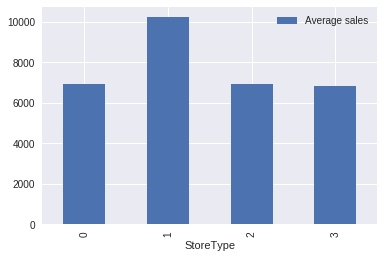

In [34]:
sales_by_store_type.plot(kind='bar', label='Average sales')
plt.legend()
plt.savefig('eda_store_type.png')

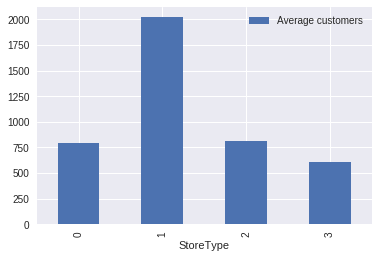

In [35]:
cust_by_store_type.plot(kind='bar', label='Average customers')
plt.legend()
plt.savefig('eda_store_type_1.png')

In [140]:
sales_by_store_type

StoreType
a     6925.697986
b    10233.380141
c     6933.126425
d     6822.300064
Name: Sales, dtype: float64

In [45]:
# Assortment

# Average Sales by Assortment
sales_by_assortment = merged_df['Sales'].groupby(merged_df.Assortment).aggregate(np.mean)

# Average Customers by Assortment
cust_by_assortment = merged_df['Sales'].groupby(merged_df.Assortment).aggregate(np.mean)



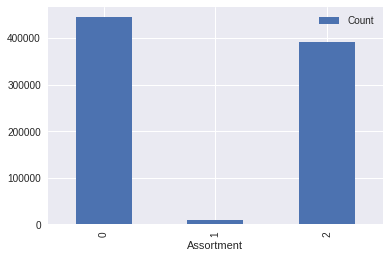

In [47]:
merged_df['Sales'].groupby(merged_df.Assortment).aggregate(np.count_nonzero).plot(kind='bar', label='Count')
plt.legend()
plt.savefig('eda_Assort_1.png')

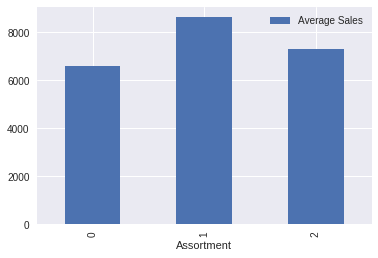

In [48]:
sales_by_assortment.plot(kind='bar', label='Average Sales')
plt.legend()
plt.savefig('eda_Assort_2.png')

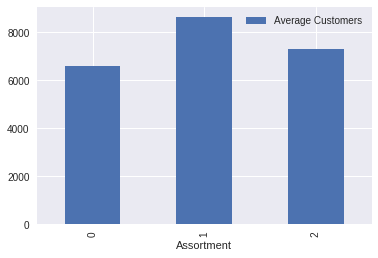

In [49]:
cust_by_assortment.plot(kind='bar', label='Average Customers')
plt.legend()
plt.savefig('eda_Assort_3.png')

In [38]:
merged_df['logCompetitionDostance'] = merged_df['CompetitionDistance'].apply(lambda x: np.log10(x))

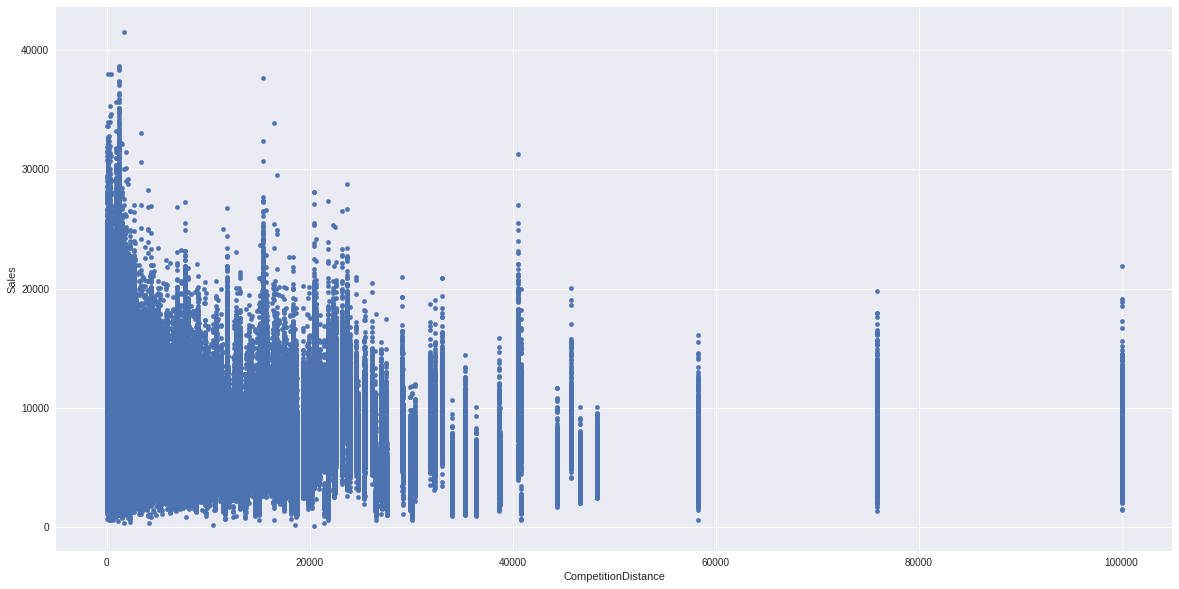

In [42]:
merged_df.plot(kind='scatter', x='CompetitionDistance',y='Sales',figsize=(20,10))
plt.savefig('Cpmpetition_distance.png')

In [34]:
pd.unique(merged_df['year'])

array([2015, 2014, 2013])

In [211]:
d = pd.DataFrame(merged_df['Sales'].groupby([merged_df.StoreType, merged_df.month]).aggregate(np.mean))



In [219]:
d.

StoreType  month
0          1         6541.448981
           2         6580.303201
           3         6942.395216
           4         7032.460480
           5         7031.343005
           6         6964.882153
           7         6931.965451
           8         6632.842194
           9         6552.029228
           10        6596.723266
           11        7155.164338
           12        8502.125711
1          1         9351.202870
           2         9945.263919
           3        10276.171070
           4        10403.402694
           5        10669.069032
           6        10563.197333
           7        10201.915912
           8         9528.931574
           9         9723.497980
           10       10064.788856
           11       10616.990909
           12       11533.773216
2          1         6557.645771
           2         6577.725298
           3         6961.774362
           4         6991.764842
           5         7070.293973
           6         6841.

In [220]:
merged_df['log_competition_distance'] = merged_df['CompetitionDistance'].apply(lambda x: np.log10(x))

In [39]:
merged_df['StateHoliday'].value_counts()

0    986159
1     20260
2      6690
3      4100
Name: StateHoliday, dtype: int64

In [221]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 24 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Date                         844338 non-null object
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null int8
SchoolHoliday                844338 non-null int64
StoreType                    844338 non-null int8
Assortment                   844338 non-null int8
CompetitionDistance          844338 non-null float64
CompetitionOpenSinceMonth    575738 non-null float64
CompetitionOpenSinceYear     575738 non-null float64
Promo2                       844338 non-null int64
Promo2SinceWeek              421046 non-null float64
Promo2SinceYear              421046 non-null float64
PromoInterval 

In [223]:
len(merged_df['Open'] == 1)

844338

In [228]:
y = open_merged_df['Sales']
X = open_merged_df.drop(['Sales', 'Date', '_date_', 'Store', 'PromoInterval', 'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionDistance','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Open', 'Customers'], axis=1)

In [229]:
selected_features = list(set(open_merged_df.columns) - set(['Sales', 'Date', '_date_', 'Store', 'PromoInterval', 'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Open', 'Customers']))

In [230]:
import gc
gc.collect()

301

In [231]:
X.head()

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,Promo2,month,day,year,Promo2_Indicator,log_competition_distance
0,5,1,0,1,2,0,0,7,31,2015,0,3.103804
1,4,1,0,1,2,0,0,7,31,2015,0,3.103804
2,3,1,0,1,2,0,0,7,31,2015,0,3.103804
3,2,1,0,1,2,0,0,7,31,2015,0,3.103804
4,1,1,0,1,2,0,0,7,31,2015,0,3.103804


In [234]:
X.isnull().sum()

DayOfWeek                   0
Promo                       0
StateHoliday                0
SchoolHoliday               0
StoreType                   0
Assortment                  0
Promo2                      0
month                       0
day                         0
year                        0
Promo2_Indicator            0
log_competition_distance    0
dtype: int64

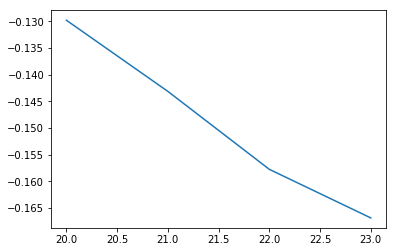

In [239]:
from sklearn.model_selection import cross_val_score
scores = []
for d in tqdm_notebook(range(20,24)):
    model =  RandomForestRegressor(max_depth=d)
    scores.append(cross_val_score(model, X, y, cv=5, scoring='r2').mean())
plt.plot(range(20,24), scores)

In [240]:
scores

[-0.12978819034513595,
 -0.14313505012763406,
 -0.15775461575721789,
 -0.16686693561270891]

In [242]:
randomForest = RandomForestRegressor(max_depth=24)
randomForest.verbose = True
randomForest.fit(X, y)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=24,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=True, warm_start=False)

In [244]:
print(sorted(zip(map(lambda x: round(x, 4), randomForest.feature_importances_), selected_features), 
             reverse=True))

[(0.50829999999999997, 'CompetitionDistance'), (0.15110000000000001, 'Promo2'), (0.083900000000000002, 'StoreType'), (0.071300000000000002, 'day'), (0.0659, 'Assortment'), (0.0327, 'Promo'), (0.024400000000000002, 'DayOfWeek'), (0.022700000000000001, 'log_competition_distance'), (0.017000000000000001, 'Promo2_Indicator'), (0.010699999999999999, 'SchoolHoliday'), (0.010500000000000001, 'month'), (0.0016000000000000001, 'year')]


## Test data


In [245]:
test_df = pd.read_csv('./test.csv')

In [248]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [52]:
test_data['Store']

0        622
1        622
2        622
3        622
4        622
5        622
6        622
7        622
8        622
9        622
10       622
11       622
12       622
13       622
14       622
15       622
16       622
17       622
18       622
19       622
20       622
21       622
22       622
23       622
24       622
25       622
26       622
27       622
28       622
29       622
        ... 
41058    622
41059    622
41060    622
41061    622
41062    622
41063    622
41064    622
41065    622
41066    622
41067    622
41068    622
41069    622
41070    622
41071    622
41072    622
41073    622
41074    622
41075    622
41076    622
41077    622
41078    622
41079    622
41080    622
41081    622
41082    622
41083    622
41084    622
41085    622
41086    622
41087    622
Name: Store, Length: 41088, dtype: int64

In [56]:
test_data[test_data['Store'] == 622]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
3903,3904,622,7,2015-09-13,0.0,0,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0


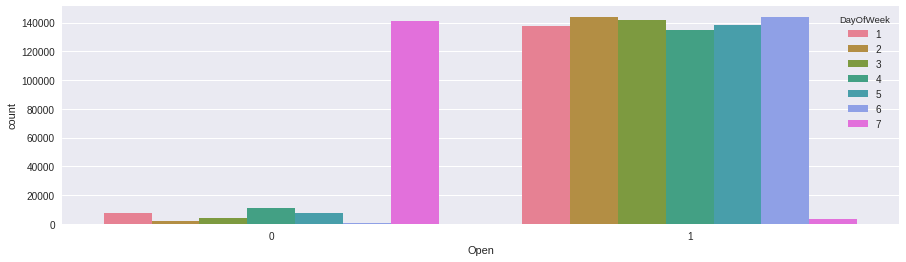

In [54]:
fig, (axis1) = plt.subplots(1,1,figsize=(15,4))
sns.countplot(x='Open',hue='DayOfWeek', data=sales_data,palette="husl", ax=axis1)
fig.savefig('sales_data_pattern.png')

## Model Building

In [7]:
# fill NaN values in test_df with Open=1 if DayOfWeek != 7
test_data["Open"][test_data["Open"] != test_data["Open"]] = (test_data["DayOfWeek"] != 7).astype(int)


/home/ashish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
sales_data["StateHoliday"] = sales_data["StateHoliday"].astype('category').cat.codes
test_data["StateHoliday"]     = test_data["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})

In [10]:
test_data["StateHoliday"].value_counts()

0    40908
1      180
Name: StateHoliday, dtype: int64

In [11]:
sales_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,1,1
1,2,5,2015-07-31,6064,625,1,1,1,1
2,3,5,2015-07-31,8314,821,1,1,1,1
3,4,5,2015-07-31,13995,1498,1,1,1,1
4,5,5,2015-07-31,4822,559,1,1,1,1


In [12]:
# Find the average number of customers and shopping purchases and combine with the store table
average_sales_customers = sales_data.groupby('Store')[["Sales", "Customers"]].mean()

sales_customers_df = pd.DataFrame({'Store':average_sales_customers.index,
                      'Sales':average_sales_customers["Sales"], 'Customers': average_sales_customers["Customers"]}, 
                      columns=['Store', 'Sales', 'Customers'])
store = pd.merge(sales_customers_df, stores_data, on='Store')

store.head()

,Store,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3945.704883,467.646497,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4122.991507,486.045648,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5741.253715,620.286624,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,8021.769639,1100.057325,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,3867.110403,444.360934,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
# CompetitionDistance

# fill NaN values
store["CompetitionDistance"] = store["CompetitionDistance"].fillna(100000)

In [14]:
# Notice that test_df has only year=2015, and months 8 & 9

# drop Year and Month
#sales_.drop(["Year", "Month"], axis=1, inplace=True)
#test_data.drop(["Year", "Month"], axis=1, inplace=True)

# Create dummy varibales for DayOfWeek
day_dummies_rossmann  = pd.get_dummies(sales_data['DayOfWeek'], prefix='Day')
day_dummies_rossmann.drop(['Day_7'], axis=1, inplace=True)

day_dummies_test  = pd.get_dummies(test_data['DayOfWeek'],prefix='Day')
day_dummies_test.drop(['Day_7'], axis=1, inplace=True)

rossmann_df = sales_data.join(day_dummies_rossmann)
test_df     = test_data.join(day_dummies_test)

rossmann_df.drop(['DayOfWeek'], axis=1,inplace=True)
test_df.drop(['DayOfWeek'], axis=1,inplace=True)


In [15]:
# remove all rows(store,date) that were closed
rossmann_df = rossmann_df[rossmann_df["Open"] != 0]

# drop unnecessary columns, these columns won't be useful in prediction
rossmann_df.drop(["Open","Customers", "Date"], axis=1, inplace=True)

In [16]:
# save ids of closed stores, because we will assign their sales value to 0 later(see below)
closed_store_ids = test_df["Id"][test_df["Open"] == 0].values

# remove all rows(store,date) that were closed
test_df = test_df[test_df["Open"] != 0]

# drop unnecessary columns, these columns won't be useful in prediction
test_df.drop(['Open', 'Date'], axis=1,inplace=True)

In [270]:
#rossmann_df["StateHoliday"] = rossmann_df["StateHoliday"].astype('category').cat.codes
#test_df['StateHoliday'] = rossmann_df['StateHoliday'].astype('category').cat.codes

In [17]:
test_df['StateHoliday'].value_counts()

0    35078
1       26
Name: StateHoliday, dtype: int64

In [19]:
rossmann_df.head()

,Store,Sales,Promo,StateHoliday,SchoolHoliday,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6
0,1,5263,1,1,1,0,0,0,0,1,0
1,2,6064,1,1,1,0,0,0,0,1,0
2,3,8314,1,1,1,0,0,0,0,1,0
3,4,13995,1,1,1,0,0,0,0,1,0
4,5,4822,1,1,1,0,0,0,0,1,0


In [18]:
test_df.head()

,Id,Store,Promo,StateHoliday,SchoolHoliday,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6
0,1,1,1,0,0,0,0,0,1,0,0
1,2,3,1,0,0,0,0,0,1,0,0
2,3,7,1,0,0,0,0,0,1,0,0
3,4,8,1,0,0,0,0,0,1,0,0
4,5,9,1,0,0,0,0,0,1,0,0


## Linear Regression

In [291]:
from sklearn.linear_model import LinearRegression
# Loop through each store, 
# train the model using the data of current store, and predict it's sales values.

rossmann_dic = dict(list(rossmann_df.groupby('Store')))
test_dic     = dict(list(test_df.groupby('Store')))
submission   = pd.Series()
scores       = []

for i in test_dic:
    
    # current store
    store = rossmann_dic[i]
    
    # define training and testing sets
    X_train = store.drop(["Sales","Store"],axis=1)
    Y_train = store["Sales"]
    X_test  = test_dic[i].copy()
    
    store_ids = X_test["Id"]
    X_test.drop(["Id","Store"], axis=1,inplace=True)
    
    # Linear Regression
    lreg = LinearRegression()
    lreg.fit(X_train, Y_train)
    Y_pred = lreg.predict(X_test)
    scores.append(lreg.score(X_train, Y_train))

    # Xgboost
    # params = {"objective": "reg:linear",  "max_depth": 10}
    # T_train_xgb = xgb.DMatrix(X_train, Y_train)
    # X_test_xgb  = xgb.DMatrix(X_test)
    # gbm = xgb.train(params, T_train_xgb, 100)
    # Y_pred = gbm.predict(X_test_xgb)
    
    # append predicted values of current store to submission
    submission = submission.append(pd.Series(Y_pred, index=store_ids))

# append rows(store,date) that were closed, and assign their sales value to 0
submission = submission.append(pd.Series(0, index=closed_store_ids))

# save to csv file
submission = pd.DataFrame({ "Id": submission.index, "Sales": submission.values})
submission.to_csv('rossmann.csv', index=False)

## XGBoost

In [295]:
rossmann_dic = dict(list(rossmann_df.groupby('Store')))
test_dic     = dict(list(test_df.groupby('Store')))
submission   = pd.Series()
scores       = []

for i in test_dic:
    
    # current store
    store = rossmann_dic[i]
    
    # define training and testing sets
    X_train = store.drop(["Sales","Store"],axis=1)
    Y_train = store["Sales"]
    X_test  = test_dic[i].copy()
    
    store_ids = X_test["Id"]
    X_test.drop(["Id","Store"], axis=1,inplace=True)
    

    # Xgboost
#   params = {"objective": "reg:linear",  "max_depth": 10}
    
    num_boost_round = 300
    T_train_xgb = xgb.DMatrix(X_train, Y_train)
    X_test_xgb  = xgb.DMatrix(X_test)
    gbm = xgb.train(params, T_train_xgb, 100)
    Y_pred = gbm.predict(X_test_xgb)
    
    # append predicted values of current store to submission
    submission = submission.append(pd.Series(Y_pred, index=store_ids))

# append rows(store,date) that were closed, and assign their sales value to 0
submission = submission.append(pd.Series(0, index=closed_store_ids))

# save to csv file
submission = pd.DataFrame({ "Id": submission.index, "Sales": submission.values})
submission.to_csv('rossmann_xgb.csv', index=False)

## Random Forest

In [ ]:

scores = []
for d in tqdm_notebook(range(20,24)):
    model =  RandomForestRegressor(max_depth=d)
    scores.append(cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean())
plt.plot(range(20,24), scores)

In [300]:
rossmann_dic = dict(list(rossmann_df.groupby('Store')))
test_dic     = dict(list(test_df.groupby('Store')))
submission   = pd.Series()
scores       = []

for i in test_dic:
    
    # current store
    store = rossmann_dic[i]
    
    # define training and testing sets
    X_train = store.drop(["Sales","Store"],axis=1)
    Y_train = store["Sales"]
    X_test  = test_dic[i].copy()
    
    store_ids = X_test["Id"]
    X_test.drop(["Id","Store"], axis=1,inplace=True)
    

    scores = []
    randomForest = RandomForestRegressor(max_depth=24)
#    randomForest.verbose = True
    randomForest.fit(X_train, Y_train)
    
    Y_pred = randomForest.predict(X_test)
    
    # append predicted values of current store to submission
    submission = submission.append(pd.Series(Y_pred, index=store_ids))

# append rows(store,date) that were closed, and assign their sales value to 0
submission = submission.append(pd.Series(0, index=closed_store_ids))

# save to csv file
submission = pd.DataFrame({ "Id": submission.index, "Sales": submission.values})
submission.to_csv('rossmann_rf.csv', index=False)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]